# Считывание данных

In [1]:
import pandas as pd
import numpy as np
import os
import re
import glob

from tqdm.notebook import tqdm

import sys

np.random.seed(10)

UNIVS = ['АлтГУ', 'АлтГТУ', 'ВолГУ', 'ИМСИТ']
CURRPATH = os.getcwd()
DATAPATH = '\\'.join(CURRPATH.split('\\')[:-1]) + '\\new-data'
CODESPATH = '\\'.join(CURRPATH.split('\\')[:-1]) + '\\codes'
FILESPATH = DATAPATH + '\\new-files'

if CODESPATH not in sys.path:
    sys.path.append(CODESPATH)

from visualization import draw_wordcloud, draw_cluster_clouds

In [2]:
def read_to_df(folder: str, threshold=350):
    df = pd.DataFrame(columns=['univ', 'prog', 'name', 'text'])
    for file in tqdm(glob.glob('{}/*/*/*.txt'.format(folder))):
        splitted = file.split('\\')
        name = splitted[-1][:-4]
        u = splitted[-3]
        op = splitted[-2]
        
        try:
            text = open(file, 'r').read()
        except Exception as e:
            print(e)
            print(file)
            text = open(file, 'r', encoding='utf-8').read()
        if len(text) < threshold:
            continue
        
        df = df.append({'univ':u, 'prog':op, 'name':name, 'text':text.lower()}, ignore_index=True)
    return df

In [3]:
df = read_to_df(DATAPATH + '\\new-files-lemm')

  0%|          | 0/2464 [00:00<?, ?it/s]

In [4]:
len(df)

2068

# Разметка данных
Чтобы упростить задачу, применим кластеризацию на Word2Vec и K-Means. Возьмем малое число кластеров, так как может быть выделено очень много категорий, что несколько излишне.

**Предполагаемые кластеры:**
* экономика/история/политика;
* языки, включая филологию, лингвистику, иностранные языки и коммуникации (oral skills);
* информатика и икт;
* математика;
* физика, химия, биология, экология и география;
* бизнес, инноватика, менеджмент, финансы и маркетинг, реклама и связи с общественностью;
* прочее: культурология, философия, журналистика;
* психология, конфликтология, социология;
* право и юриспруденция, обществознание.

Педагогическое образование -- возможно выделение в отдельный кластер.

In [5]:
%load_ext autoreload

In [6]:
%autoreload 2
import gensim
from gensim.models import Word2Vec
from hyperparameters import w2v_kwargs_small

corpus = df.text.tolist()
corpus_splitted = [text.split() for text in corpus]

w2v_vec_skip = Word2Vec(**w2v_kwargs_small, sg=1, hs=0)
w2v_vec_skip.build_vocab(corpus_splitted)
w2v_vec_skip.train(corpus_splitted, total_examples=w2v_vec_skip.corpus_count, epochs=w2v_vec_skip.epochs)

(3977920, 4233280)

In [8]:
%autoreload 2
from utils import idf_mean_vectorizer

w2v_skip_dict = dict(zip(w2v_vec_skip.wv.index_to_key, w2v_vec_skip.wv.vectors))
X_skip_idf = idf_mean_vectorizer(w2v_skip_dict).fit_transform(corpus)
X_skip_idf.shape

(2068, 2500)

In [9]:
%autoreload 2
from hyperparameters import kmeans_kwargs_small
from sklearn.cluster import KMeans
N_CLUSTERS = 11

km = KMeans(**kmeans_kwargs_small, n_clusters=N_CLUSTERS).fit(X_skip_idf)
km_labels = km.labels_

cluster: 1; samples: 168


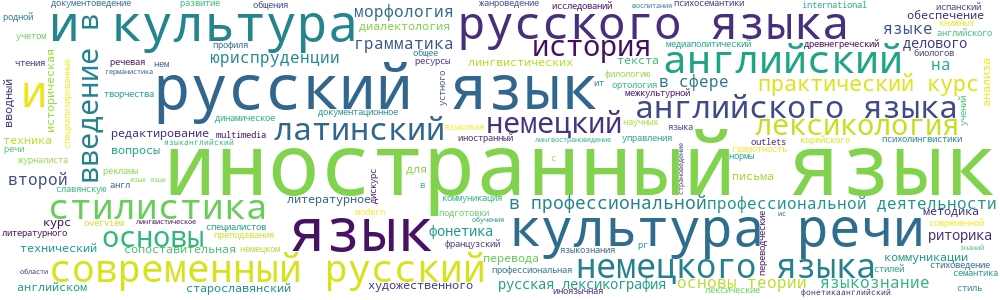

cluster: 2; samples: 145


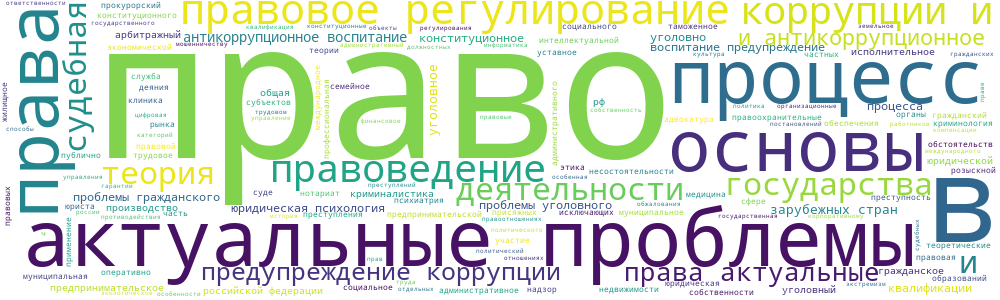

cluster: 3; samples: 244


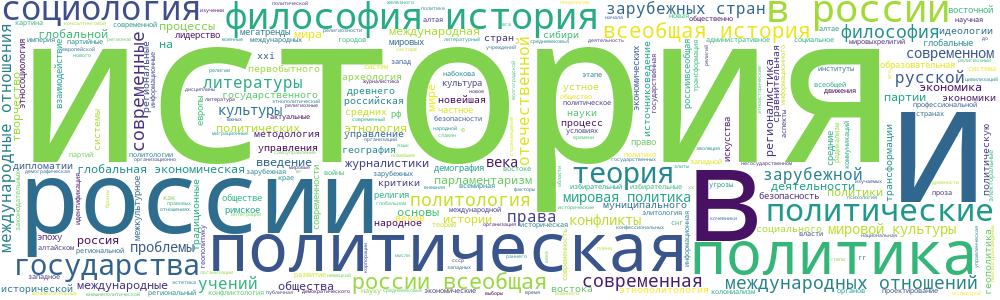

cluster: 4; samples: 161


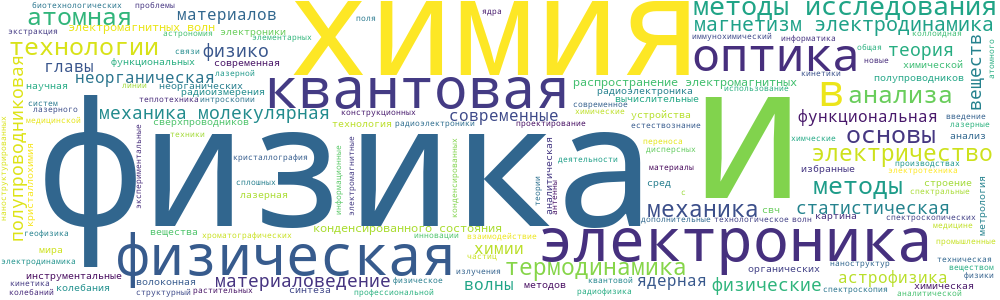

cluster: 5; samples: 235


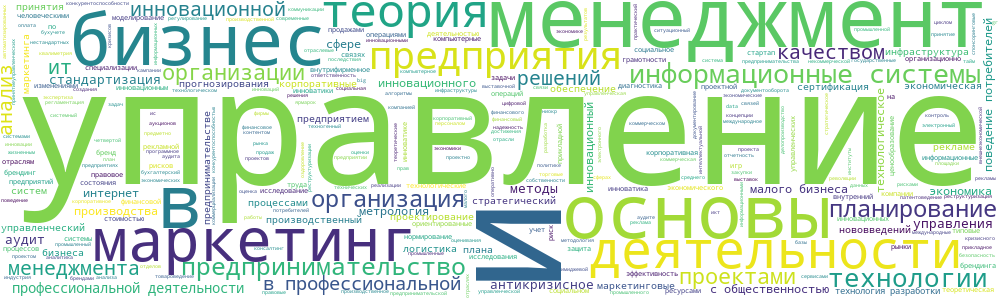

cluster: 6; samples: 379


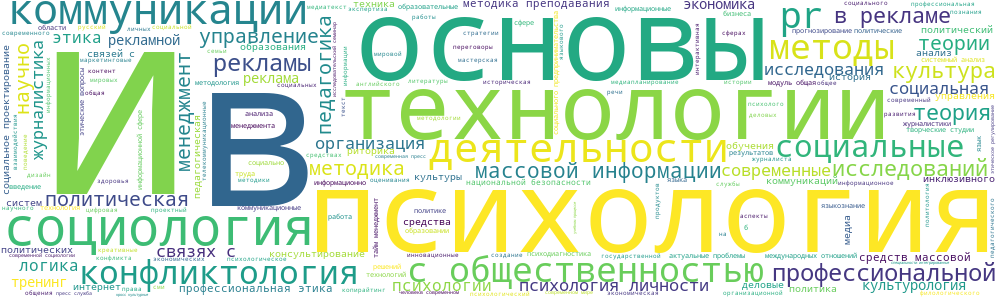

cluster: 7; samples: 69


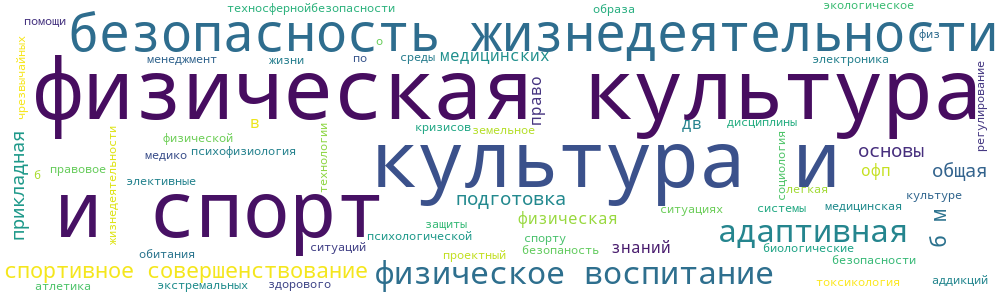

cluster: 8; samples: 145


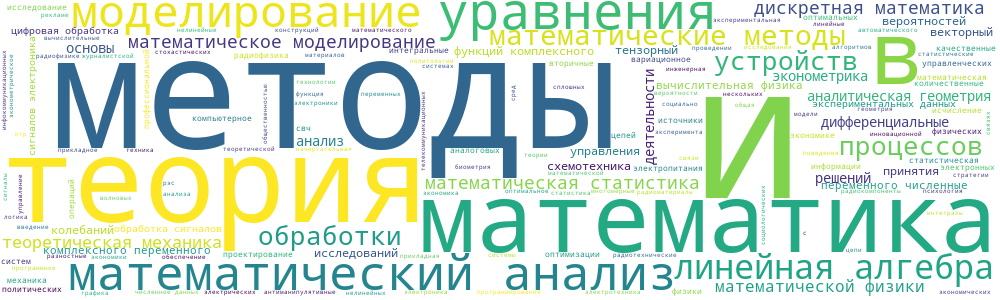

cluster: 9; samples: 195


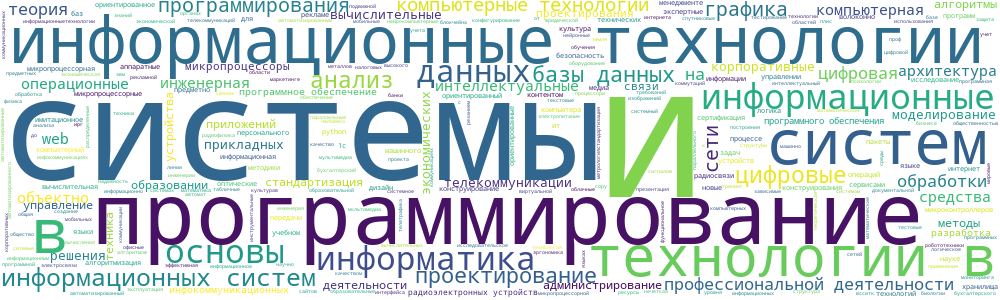

cluster: 10; samples: 184


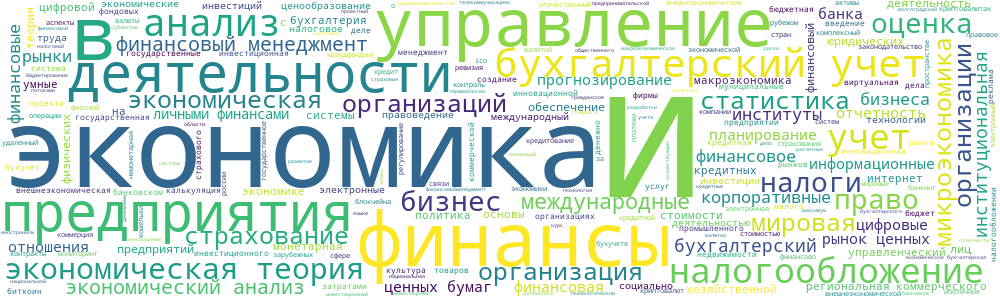

cluster: 11; samples: 143


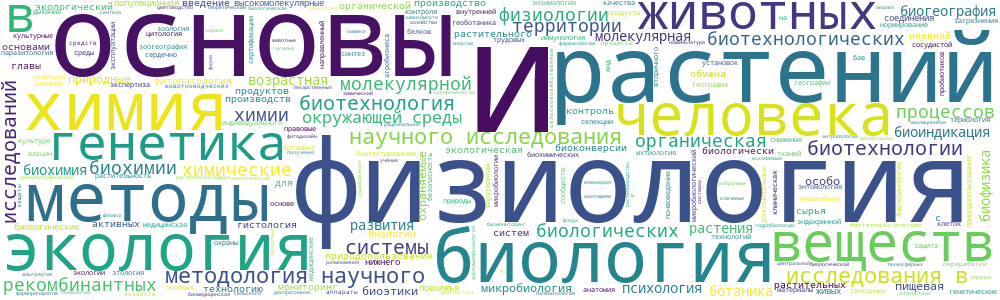

In [10]:
cloud_kwargs = { 'max_words':2000, 'width':1000, 'height':300 }
draw_cluster_clouds(df, km_labels, N_CLUSTERS, alert_by='name', cloud_kwargs=cloud_kwargs)

## Автоматизированная разметка
Теперь мы можем разметить часть данных автоматизированно, а часть -- вручную, исправляя ошибки автоматической разметки.

In [11]:
df['cluster'] = ''

In [12]:
from metrics import get_inds

clusters_name = {
    1:'языки',
    2:'право',
    3:'история и политика',
    4:'физика и химия',
    5:'бизнес, менеджмент и маркетинг', # + инноватика
    6:'психология, социология и приложения', # + философия и логика, педагогика
    7:'бжд и спорт',
    8:'математика',
    9:'информатика', # информатика, ис, ит, икт и тд
    10:'экономика и финансы', # имеется в виду экономика на стыке с правом -- инвестиции, налоги
    11:'химия, биология, экология и география',
}

In [69]:
for i in range(1, 12):
    df.loc[get_inds(km_labels, i - 1), 'cluster'] = clusters_name[i]

Некоторые кластеры можно вынести отдельно.

In [70]:
df_copy = df.copy()

In [71]:
%autoreload 2
from utils import reclusterize

In [72]:
df_copy.cluster = df_copy.apply(lambda x: pd.Series(reclusterize(x, by='полит', new_cluster='история и политика')), axis=1)

In [73]:
# df_copy.cluster = df_copy.apply(lambda x: pd.Series(reclusterize(x,
#                                                     by=['психолог', 'конфликт'],
#                                                     new_cluster='психология и конфликтология')), axis=1)

In [74]:
inds = df_copy.loc[df_copy.name == 'безопасность жизнедеятельности'].index
df_copy.loc[inds, 'cluster'] = 'бжд'

In [75]:
inds = df_copy.loc[df_copy.cluster == 'бжд и спорт'].index
df_copy.loc[inds, 'cluster'] = 'спорт'

## Ручная разметка

In [59]:
%autoreload 2
from IPython.display import display, clear_output
from time import sleep

from utils import markup

In [23]:
markup(df_copy, km_labels, 1, folder='markup-1')

167 from 167
ИНОСТРАННЫЙ ЯЗЫК В ПРОФЕССИОНАЛЬНОЙ ДЕЯТЕЛЬНОСТИ 
	 языки



In [27]:
markup(df_copy, km_labels, 2, folder='markup-1')

144 from 144
ПРОТИВОДЕЙСТВИЯ КОРРУПЦИИ И КОРПОРАТИВНОМУ МОШЕННИЧЕСТВУ 
	 право



In [35]:
markup(df_copy, km_labels, 3, folder='markup-1')

243 from 243
ФИЛОСОФИЯ 
	 история и политика
прочее


In [36]:
markup(df_copy, km_labels, 4, folder='markup-1')

160 from 160
ХИМИЯ И МАТЕРИАЛОВЕДЕНИЕ 
	 физика и химия



In [37]:
markup(df_copy, km_labels, 5, folder='markup-1')

234 from 234
ПРАКТИЧЕСКИЙ АУДИТ АНАЛИЗ РИСКОВ БИЗНЕС-ПРОЦЕССОВ 
	 бизнес, менеджмент и маркетинг



In [60]:
markup(df_copy, km_labels, 7, folder='markup-1')

68 from 68
ФИЗИЧЕСКАЯ КУЛЬТУРА И СПОРТ 
	 спорт



In [61]:
markup(df_copy, km_labels, 8, folder='markup-1')

144 from 144
ЭКОНОМЕТРИКА 
	 математика



In [63]:
markup(df_copy, km_labels, 9, folder='markup-1')

194 from 194
ЭКОНОМИЧЕСКАЯ ИНФОРМАТИКА 
	 информатика



In [77]:
markup(df_copy, km_labels, 10, folder='markup-1')

183 from 183
ЭКОНОМИЧЕСКАЯ ТЕОРИЯ 
	 экономика и финансы



In [76]:
markup(df_copy, km_labels, 11, folder='markup-1')

142 from 142
ЭКОЛОГИЯ 
	 химия, биология, экология и география



Следующий кластер представляет собой сборную солянку всего, что только можно: от психологии, социологии и этики до коммуникаций, философии и педагогики. В целом, все это представляет собой нечто близкое по духу, поэтому имеет смысл рассматривать все это в рамках одного кластера.

В кластере также присутствуют дисциплины из направлений "реклама и связи с общественностью" и "журналистика", а также и  культурологические дисциплины, которые будем отделять.

In [78]:
markup(df_copy, km_labels, 6, folder='markup-1')

378 from 378
ТРЕНИНГ ЭФФЕКТИВНЫЕ БИЗНЕС-КОММУНИКАЦИИ 
	 психология, социология и приложения



In [111]:
df_copy.cluster = df_copy.apply(lambda x: pd.Series(reclusterize(x, by='механика', new_cluster='физика и химия')), axis=1)

Cчитываем скорректируемую разметку.

In [149]:
for filename in glob.glob(CURRPATH + '\\markup-1\\*.txt'):
    cind = int(filename.split('\\')[-1][:-4])
    
    file = open(filename, 'r', encoding='ansi')
    splitted = file.read().split('; ')[:-1]
    file.close()
    
    inds = get_inds(km_labels, cind - 1)    
    df_copy.loc[inds, 'cluster'] = splitted

In [150]:
df_copy.cluster.unique()

array(['бизнес, менеджмент и маркетинг', 'бжд', 'экономика и финансы',
       'психология, социология и приложения', 'языки',
       'история и политика', 'математика', 'право', 'информатика',
       'прочее', 'спорт', 'физика и химия', 'медиа и реклама',
       'химия, биология, экология и география'], dtype=object)

Распределяем кластер 'прочее'.

In [154]:
other = df_copy[df_copy.cluster == 'прочее']
other_inds = other.index
other

,univ,prog,name,text,cluster
46,АлтГТУ,производственный менеджмент,социология,коллектив толерантный этнический конфессиональ...,прочее
67,АлтГТУ,производственный менеджмент,философия,философский мировоззренческий самоорганизация ...,прочее
94,АлтГТУ,управление инновационными проектами,методы научно-технического творчества,спланировать эксперимент адекватный исследоват...,прочее
109,АлтГТУ,управление инновационными проектами,социология,коллектив толерантный этнический конфессиональ...,прочее
123,АлтГТУ,управление инновационными проектами,философия,философский мировоззренческий самоорганизация ...,прочее
...,...,...,...,...,...
1982,ИМСИТ,реклама и связи с общественностью 3++,история мировой литературы и исскуства,эволюция художественный многообразие приобрете...,прочее
1987,ИМСИТ,реклама и связи с общественностью 3++,культурология,целостный выполнять адаптация инкультурация со...,прочее
2015,ИМСИТ,реклама и связи с общественностью 3++,философия,философия философия открытие онтология мысль с...,прочее
2034,ИМСИТ,экономика финансы и учёт 3++,методология научного исследования экономически...,участник инициатор организатор исследовательск...,прочее


In [157]:
def markup_other(df, inds):    
    N = len(df)
    for num, ind in enumerate(inds):
        clear_output(wait=True)
        print('{} from {}'.format(num, N - 1))
        
        r = df.loc[ind]
        print(r['name'].upper(), '\n\t', r['cluster'])
        sleep(0.35)
        
        _ = input()
        if _ == 'text':
            display(r['text'])
            sleep(0.35)
            _ = input()

        if _ == 'break':
            file.close()
            return
        elif _ == '' or _ == '\n':
            _ = r['cluster']

        try:
            file = open('markup-1\\0.txt', 'a', encoding='ansi')
            file.write(_ + '; ')
            file.close() 
        except Exception as e:
            print('FATAL:', e)
            break

In [158]:
markup_other(other, other_inds)

84 from 84
ФИЛОСОФИЯ 
	 прочее
психология, социология и приложения


In [164]:
file = open(CURRPATH + '\\markup-1\\0.txt', 'r', encoding='ansi')
splitted = file.read().split('; ')[:-1]
file.close()
    
df_copy.loc[other_inds, 'cluster'] = splitted

In [171]:
df_copy.to_csv('data.csv')